# CCAMLR Network Structure Investigation
We're going to work out what the structure of the CCAMLR network is.

# Read the Data

Get the data from the Excel file. lower_year_threshold and upper_year_threshold track the network between two given years.


In [54]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from itertools import combinations,combinations_with_replacement

lower_year_threshold = 1980  # Define your lower year threshold
upper_year_threshold = 2023  # Define your upper year threshold

# Read the CCAMLR dataset and initialise it into a Pandas Dataframe
def read_CCAMLR_dataset():
    # Define the path to the Excel file
    file_path = 'CCAMLR.xlsx'

    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_path,sheet_name='WP only')
    df['Year'] = df['Year'].astype(int)

    # Display the DataFrame
    return df

# Df is the returned pandas dataframe.
df = read_CCAMLR_dataset()
print(df)



               Reference                                           Document  \
0                     R1                         Proposal to amend CM 10-02   
1                     R2                      Proposal to amend CM 10-09 r1   
2    CCAMLR-41/25 Rev. 1  Amendments to CCAMLR Conservation Measures 21‐...   
3    CCAMLR-41/26 Rev. 1       Proposal to amend Conservation Measure 26-01   
4           CCAMLR-41/27  Draft conservation measure for an East Antarct...   
..                   ...                                                ...   
404   CCAMLR-I/24 Rev. 1           Amendment to Draft Financial Regulations   
405          CCAMLR-I/26  Proposed Amendments to the Draft Headquarters ...   
406          CCAMLR-I/30  Amendments to the Draft Headquarters Agreement...   
407          CCAMLR-I/36  Draft Interim Agreement between the Government...   
408    CCAMLR-I/9 Rev. 1              Draft Budget Estimates, 1982 and 1983   

     Year                          Topic Paper_type

# Initialise the Network- Step 1
Initialise the node names of the various countries. <br>


NODES:  ['Chile', 'Argentina', 'France', 'United Kingdom', 'Germany', 'Technical Working Group', 'Ukraine', 'Namibia', 'Korea (ROK)', 'China', 'Belgium', 'New Zealand', 'Russian Federation', 'Brazil', 'Spain', 'EEC', 'Poland', 'Secretariat', 'Japan', 'Italy', 'Australia', 'Norway', 'EU', 'South Africa', 'India', 'Uruguay', 'VMS', 'United States', 'CDS', 'Sweden', 'DOCEP']
31


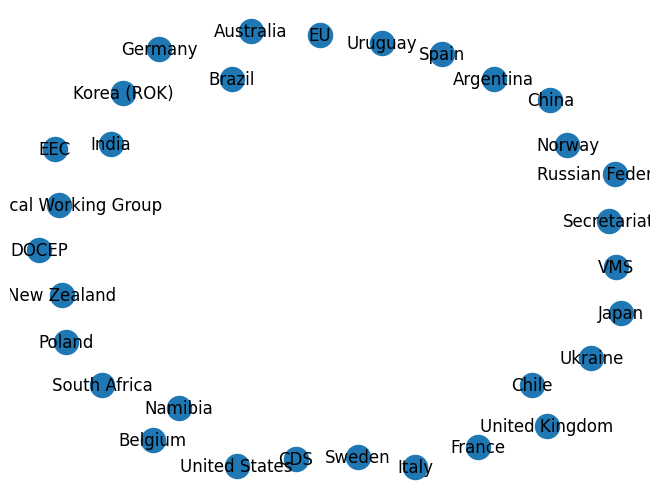

In [55]:
# Find all the nodes in the graph. 
def get_nodes(df):
    # Go through each cell of the dataframe and look for unique authors to set as nodes.
    author_columns = [f'Author {i}' for i in range(1, 11)]
    nodes=set()
    # For each cell in the section that we need to look through
    for col in author_columns:
        for row in filtered_df.index:
            author = filtered_df.at[row, col]
            # If the row is not blank
            if pd.notna(author):
                # Add the author in if we don't have it. 
                if author not in nodes:
                    nodes.add(author)
    nodes=list(nodes)
    return nodes

filtered_df = df[(df['Year'] <= upper_year_threshold) & (df['Year'] >= lower_year_threshold)]
# Get the nodes using the function above.
nodes = get_nodes(df)
print("NODES: " , nodes)
print(len(nodes))

# Initialize the network in networkx
CCAMLR_network = nx.Graph()

# Add nodes to the graph
CCAMLR_network.add_nodes_from(nodes)

# Draw the network
nx.draw(CCAMLR_network, with_labels=True)
plt.show()



# Initialise the Network- Step 2
Create the graph with an edge between nodes $a$ and $b$ if they share at least one working paper. <br>
The weight of this edge is given by the number of working papers that $a$ and $b$ have collaborated on in the dataset. <br>

124
31


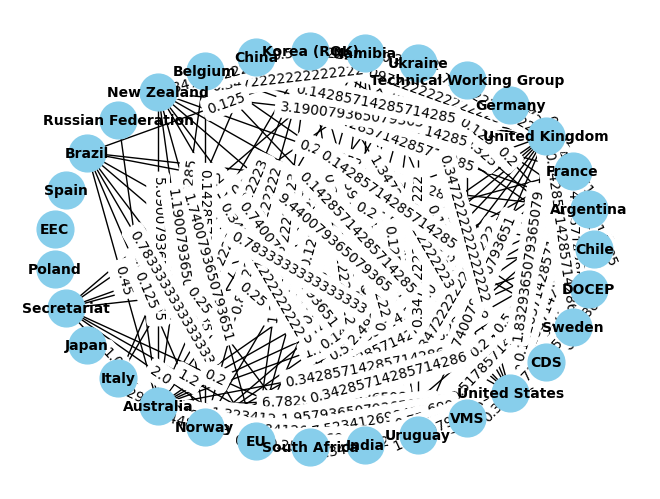

In [56]:
def add_edges(df, CCAMLR_network):
    """
    For each working paper (each row in the DataFrame), this function
    adds weighted edges between all pairs of authors present in the paper.
    
    The weight w_ij between two nodes i and j is defined as:
    
        w_ij = sum_p { (δ_i^p δ_j^p) / (n_p - 1) }   for i ≠ j
        w_ii = 0
    
    where:
      - The sum runs over all papers,
      - n_p is the number of authors in paper p,
      - δ_i^p is 1 if author i contributed to paper p and 0 otherwise.
    """
    # Define the author columns.
    author_columns = [f'Author {i}' for i in range(1, 11)]
    
    # For each paper (each row in the DataFrame)
    for idx, row in df[author_columns].iterrows():
        # Get authors for this paper (ignoring missing values and extra whitespace)
        authors = [str(author).strip() for author in row if pd.notna(author) and str(author).strip() != '']
        
        # Retain only those authors who are present in the CCAMLR network nodes.
        authors = [a for a in authors if a in CCAMLR_network.nodes]
        n_p = len(authors)
        
        # Only proceed if there is more than one author in the paper.
        if n_p > 1:
            contribution = 1 / (n_p - 1)
            # Loop over all unique pairs of authors (i, j)
            for i in range(n_p):
                for j in range(i + 1, n_p):
                    a_i = authors[i]
                    a_j = authors[j]
                    
                    # If an edge already exists between these two authors, add the contribution;
                    # otherwise, create a new edge with the contribution as its weight.
                    if CCAMLR_network.has_edge(a_i, a_j):
                        CCAMLR_network[a_i][a_j]['weight'] += contribution
                    else:
                        CCAMLR_network.add_edge(a_i, a_j, weight=contribution)
    return

add_edges(filtered_df,CCAMLR_network)

# Test the edge collection, to see if it is correct. 
#Checked and looks good!
# e.g correctly reports that Australia and Norway share 15 working papers together.
#print(CCAMLR_network["Australia"]["Norway"]["weight"])

# Visualize the network
pos = nx.circular_layout(CCAMLR_network)  # Positions for all nodes with specified spacing
nx.draw(CCAMLR_network, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(CCAMLR_network, 'weight')
nx.draw_networkx_edge_labels(CCAMLR_network, pos, edge_labels=edge_labels)
print(len(CCAMLR_network.edges))
print(len(CCAMLR_network.nodes))

plt.show()

# Check Degree Distribution of the network
Graph the degree distribution in Matplotlib and see what it looks like. 

Chile 15
Argentina 13
France 9
United Kingdom 16
Germany 0
Technical Working Group 1
Ukraine 13
Namibia 11
Korea (ROK) 12
China 2
Belgium 7
New Zealand 11
Russian Federation 1
Brazil 9
Spain 0
EEC 0
Poland 0
Secretariat 9
Japan 0
Italy 2
Australia 19
Norway 16
EU 16
South Africa 13
India 13
Uruguay 14
VMS 1
United States 17
CDS 0
Sweden 8
DOCEP 0
AVERAGE DEGREE:  8.0
DEGREE SEQUENCE:  [15, 13, 9, 16, 0, 1, 13, 11, 12, 2, 7, 11, 1, 9, 0, 0, 0, 9, 0, 2, 19, 16, 16, 13, 13, 14, 1, 17, 0, 8, 0]
Degree Distribution Power Law Fit Coefficients (a, b): [0.13263669 0.64656804]


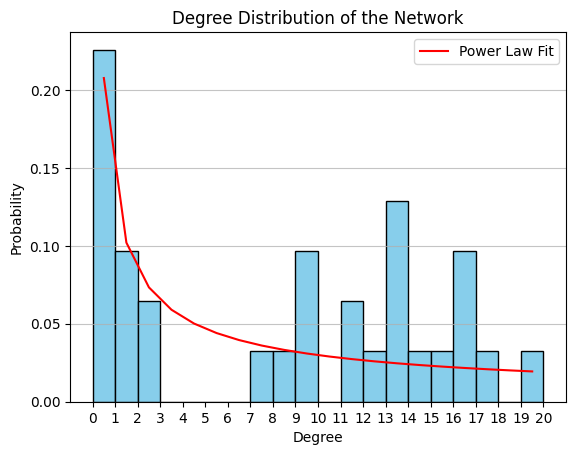

WEIGHT SEQUENCE:  [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.25, 0.25, 0.25, 0.25, 0.25, 0.26785714285714285, 0.26785714285714285, 0.325, 0.325, 0.34285714285714286, 0.34285714285714286, 0.34285714285714286, 0.34285714285714286, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.3472222222222222, 0.4222222222222222, 0.45, 0.45, 0.45, 0.5, 0.5, 0.5, 0.5, 0.5178571428571428, 0.5178571428571428, 0.

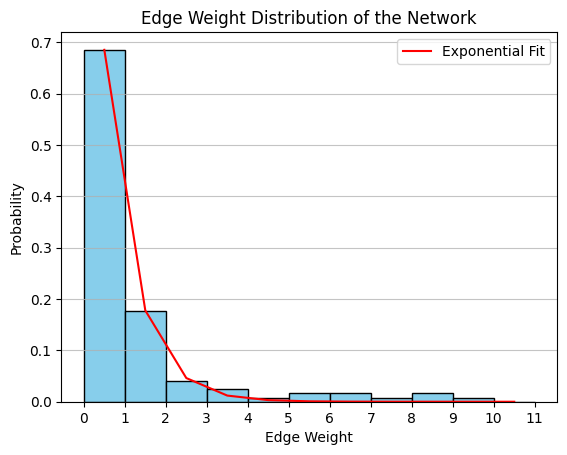

STRENGTHS
[0, 0, 0, 0, 0, 0, 0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 4.0, 4.000000000000001, 4.000000000000001, 7.0, 7.0, 8.0, 10.0, 10.0, 12.999999999999996, 17.999999999999996, 21.999999999999996, 23.999999999999996, 24.999999999999993, 35.0, 36.0, 46.00000000000001]


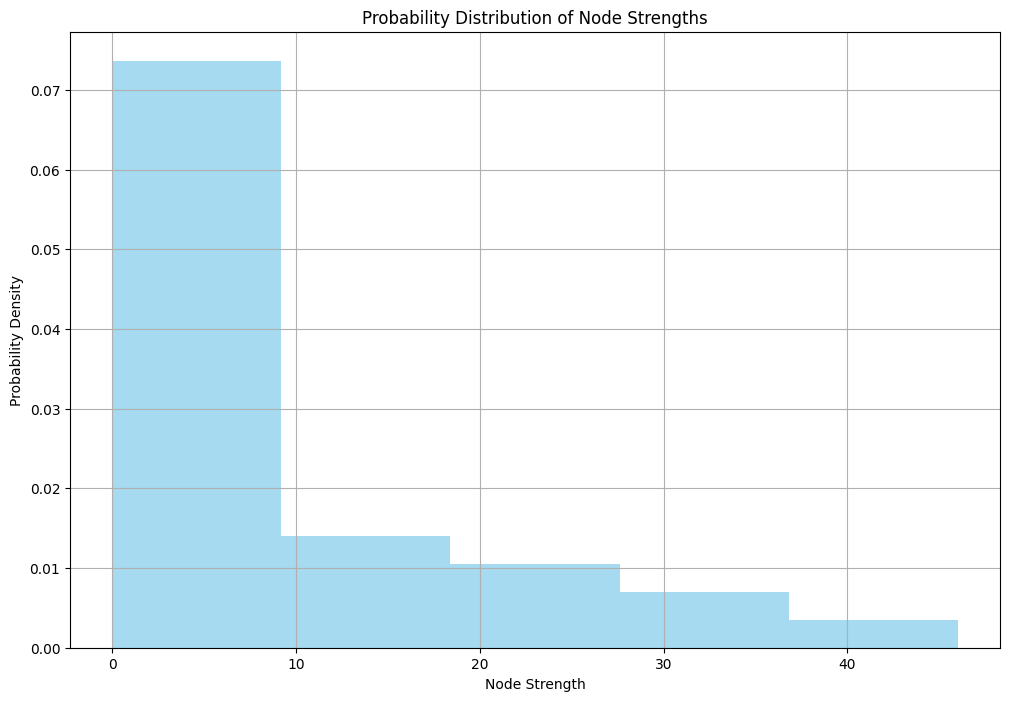

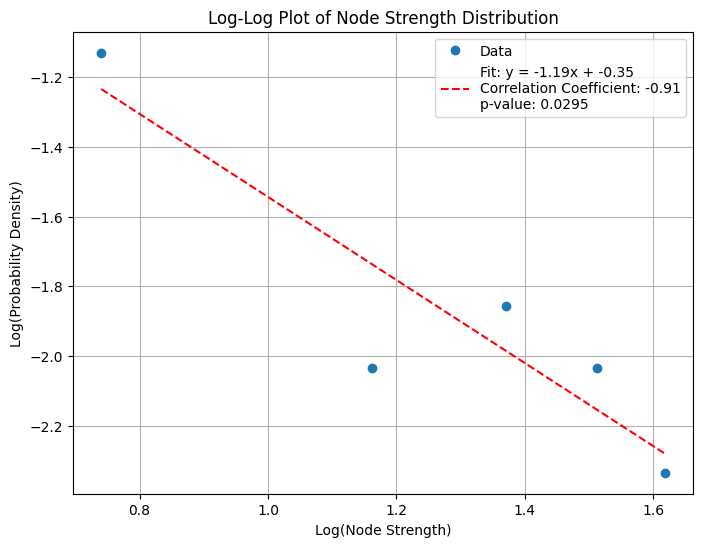

Correlation Coefficient: -0.91
p-value: 0.0295


In [57]:
# Plot a histogram of the degree.
def plot_degree_distribution(CCAMLR_network):
    # Define power-law function
    def power_law(x, a, b):
        return a * x**(-b)
    
    # Plot the degree distribution as a probability distribution
    degrees = [CCAMLR_network.degree(node) for node in CCAMLR_network.nodes()]
    av=0
    for i in CCAMLR_network.nodes():
        print(i, CCAMLR_network.degree(i))
        av+=CCAMLR_network.degree(i)
    av/=len(CCAMLR_network.nodes())
    print("AVERAGE DEGREE: ", str(av))
    print("DEGREE SEQUENCE: ", degrees)
    
    # Since degrees are integers, using range() is fine here.
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2),
             density=True, color='skyblue', edgecolor='black')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree Distribution of the Network')
    plt.xticks(range(min(degrees), max(degrees) + 2))
    plt.grid(axis='y', alpha=0.75)

    # Regression model on the power law.
    bin_centers = np.array(range(min(degrees), max(degrees) + 1)) + 0.5
    hist, bin_edges = np.histogram(degrees, bins=range(min(degrees), max(degrees) + 2), density=True)
    popt, _ = curve_fit(power_law, bin_centers, hist)

    print("Degree Distribution Power Law Fit Coefficients (a, b):", popt)
    plt.plot(bin_centers, power_law(bin_centers, *popt), 'r-', label='Power Law Fit')
    plt.legend()
    plt.show()


def plot_weight_distribution(CCAMLR_network):
    # Define an exponential function for the fit.
    def exponential(x, a, b):
        return a * np.exp(-b * x)

    # Calculate edge weight distribution
    edge_weights = [CCAMLR_network[edge[0]][edge[1]]['weight'] for edge in CCAMLR_network.edges()]
    edge_weights.sort()
    print("WEIGHT SEQUENCE: ", edge_weights)
    
    # Convert min and max edge weights to integers for binning.
    min_weight = int(np.floor(min(edge_weights)))
    max_weight = int(np.ceil(max(edge_weights)))
    
    # Use np.arange to define bin edges since edge_weights are floats.
    bins = np.arange(min_weight, max_weight + 2, 1)
    
    # Plot the edge weight distribution using the new bins.
    plt.hist(edge_weights, bins=bins, density=True, color='skyblue', edgecolor='black')
    plt.xlabel('Edge Weight')
    plt.ylabel('Probability')
    plt.title('Edge Weight Distribution of the Network')
    plt.xticks(bins)
    plt.grid(axis='y', alpha=0.75)

    # Calculate histogram for curve fitting.
    bin_centers = np.array(np.arange(min_weight, max_weight + 1, 1)) + 0.5
    hist, bin_edges = np.histogram(edge_weights, bins=bins, density=True)
    popt, _ = curve_fit(exponential, bin_centers, hist)
    print("Weight Distribution Exponential Fit Coefficients (a, b):", popt)
    plt.plot(bin_centers, exponential(bin_centers, *popt), 'r-', label='Exponential Fit')
    plt.legend()
    plt.show()


def plot_node_strength_distribution(CCAMLR_network):
    # Calculate node strengths (sum of weights of all connections for each node)
    node_strengths = {node: sum(data['weight'] for _, _, data in CCAMLR_network.edges(node, data=True))
                      for node in CCAMLR_network.nodes}
    
    # Extract strengths and plot the histogram
    strengths = list(node_strengths.values())
    print("STRENGTHS")
    strengths.sort()
    print(strengths)
    
    plt.figure(figsize=(12, 8))
    plt.hist(strengths, bins=5, density=True, alpha=0.75, color='skyblue')
    plt.xlabel('Node Strength')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of Node Strengths')
    plt.grid(True)
    plt.show()


def plot_log_log_strength_distribution(CCAMLR_network):
    # Calculate node strengths
    node_strengths = {node: sum(data['weight'] for _, _, data in CCAMLR_network.edges(node, data=True))
                      for node in CCAMLR_network.nodes}

    # Remove nodes with zero strength and calculate the log-log data
    filtered_strengths = [strength for strength in node_strengths.values() if strength > 0]
    hist, bin_edges = np.histogram(filtered_strengths, bins=5, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Filter out zero values in the histogram
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = bin_centers[non_zero_indices]

    # Calculate the logarithms
    log_bin_centers = np.log10(bin_centers)
    log_hist = np.log10(hist)

    # Fit a line to the log-log data using linear regression
    slope, intercept, r_value, p_value, std_err = linregress(log_bin_centers, log_hist)

    # Create the log-log plot
    plt.figure(figsize=(8, 6))
    plt.plot(log_bin_centers, log_hist, marker='o', linestyle='none', label='Data')
    plt.xlabel('Log(Node Strength)')
    plt.ylabel('Log(Probability Density)')
    plt.title('Log-Log Plot of Node Strength Distribution')

    # Plot the fitted line
    plt.plot(log_bin_centers, slope * log_bin_centers + intercept, color='red', linestyle='--',
             label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nCorrelation Coefficient: {r_value:.2f}\n'
                   f'p-value: {p_value:.4f}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the correlation coefficient and p-value
    print(f"Correlation Coefficient: {r_value:.2f}")
    print(f"p-value: {p_value:.4f}")
plot_degree_distribution(CCAMLR_network)
plot_weight_distribution(CCAMLR_network)
plot_node_strength_distribution(CCAMLR_network)
plot_log_log_strength_distribution(CCAMLR_network)


# What type of network is this?
Now I'm really getting excited! There's some serious Power Law dynamics happening in this graph.
Let's test preferential attachment and small world on this model. <br>

Our fits are pretty good. What about clustering in the network? <br>

It looks like it's a small-world network, based on high clustering coefficient, power law distribution, and sigma and omega measures.


0.7629139072847683
0.5579309451825183


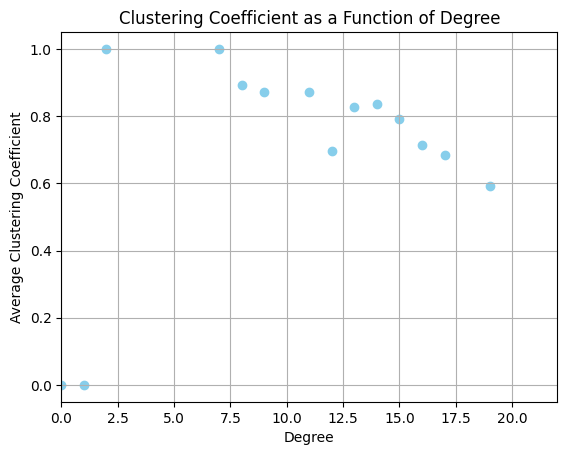

{'Chile', 'Argentina', 'France', 'United Kingdom', 'Ukraine', 'Namibia', 'Korea (ROK)', 'China', 'Belgium', 'New Zealand', 'Russian Federation', 'Brazil', 'Secretariat', 'Italy', 'Australia', 'Norway', 'EU', 'South Africa', 'India', 'Uruguay', 'United States', 'Sweden'}
1.5454545454545454
1.056378915202445
-0.029691876750700286


In [58]:
# Clustering coefficient.
# Global clustering
print(nx.transitivity(CCAMLR_network))
# Average node clustering
print(nx.average_clustering(CCAMLR_network))

# Graph node clustering as a function of degree
def plot_clustering_vs_degree(G):
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)

    degree_clustering = {}
    for node, degree in degrees.items():
        if degree not in degree_clustering:
            degree_clustering[degree] = []
        degree_clustering[degree].append(clustering_coeffs[node])

    avg_clustering = {degree: np.mean(clustering_coeffs) for degree, clustering_coeffs in degree_clustering.items()}
    
    degrees = list(avg_clustering.keys())
    clustering_values = list(avg_clustering.values())

    plt.scatter(degrees, clustering_values, color='skyblue')
    plt.xlabel('Degree')
    plt.ylabel('Average Clustering Coefficient')
    plt.xlim((0,22))
    plt.title('Clustering Coefficient as a Function of Degree')
    plt.grid(True)
    plt.show()

plot_clustering_vs_degree(CCAMLR_network)

# If we remove the disconnected bits and take the largest connected component, then we can run the small world measures.
largest_cc = max(nx.connected_components(CCAMLR_network), key=len)
print(largest_cc)
sub = CCAMLR_network.subgraph(largest_cc).copy()

print(nx.average_shortest_path_length(sub))

print(nx.sigma(sub))
print(nx.omega(sub))


#  Rank Correlation Analysis of CCAMLR



In [59]:
def get_strength_rankings(t_lower, t_upper, df):
    
    
    # Filter the dataframe for the specified time period
    filtered_df = df[(df['Year'] <= t_upper) & (df['Year'] >= t_lower)]
    
    # Get nodes (countries) involved in the given time frame
    nodes = get_nodes(filtered_df)
    
    
    # Initialize the network
    CCAMLR_network = nx.Graph()
    
    # Add nodes and edges to the network
    CCAMLR_network.add_nodes_from(nodes)
    add_edges(filtered_df, CCAMLR_network)
    
    # Calculate node strengths
    node_strengths = {node: sum(data['weight'] for _, _, data in CCAMLR_network.edges(node, data=True)) for node in CCAMLR_network.nodes}
    
    # Sort the nodes alphabetically
    sorted_node_strengths = sorted(node_strengths.items(), key=lambda item: item[0])
    
    return sorted_node_strengths



def calculate_spearman_rho(rankings_t1, rankings_t2):
    # Extract the countries and their strengths from both rankings
    countries_t1 = {country: strength for country, strength in rankings_t1}
    countries_t2 = {country: strength for country, strength in rankings_t2}
    
    # Ensure both rankings have the same countries (intersection)
    common_countries = set(countries_t1.keys()).intersection(set(countries_t2.keys()))
    
    # Sort the common countries alphabetically
    sorted_countries = sorted(common_countries)
    
    # Extract the strengths for the common countries
    strengths_t1 = [countries_t1[country] for country in sorted_countries]
    strengths_t2 = [countries_t2[country] for country in sorted_countries]
    
    # Calculate Spearman's rank correlation coefficient and p-value
    rho, p_value = spearmanr(strengths_t1, strengths_t2)
    
    return rho, p_value


periods=[2000,2005,2010,2015,2023]



def is_subset_period(t1_lower, t1_upper, t2_lower, t2_upper):
    """
    Returns True if the period (t1_lower, t1_upper) is a subset of 
    (t2_lower, t2_upper) or vice versa.
    """
    return (t1_lower >= t2_lower and t1_upper <= t2_upper) or \
           (t2_lower >= t1_lower and t2_upper <= t1_upper)

def average_spearman_rho_with_test(periods, df):
    spearman_rhos = []
    p_values = []
    
    # Generate all combinations for t1 and t2 pairs
    for t1_lower, t1_upper in combinations(periods, 2):
        if t1_lower <= t1_upper:
            rankings_t1 = get_strength_rankings(t1_lower, t1_upper, df)
            for t2_lower, t2_upper in combinations(periods, 2):
                # Ensure periods are valid, distinct, and not subsets of one another
                if (t2_lower <= t2_upper and 
                    (t1_lower, t1_upper) != (t2_lower, t2_upper) and 
                    not is_subset_period(t1_lower, t1_upper, t2_lower, t2_upper)):
                    
                    rankings_t2 = get_strength_rankings(t2_lower, t2_upper, df)
                    
                    # Calculate the Spearman rank correlation coefficient and p-value
                    rho, p_value = calculate_spearman_rho(rankings_t1, rankings_t2)
                    spearman_rhos.append(rho)
                    p_values.append(p_value)

                    print((t1_lower,t1_upper), (t2_lower,t2_upper),rho,p_value)
    
    # Calculate the average Spearman rank correlation coefficient and p-value
    average_rho = sum(spearman_rhos) / len(spearman_rhos) if spearman_rhos else 0
    average_p_value = sum(p_values) / len(p_values) if p_values else 1
    
    return average_rho, average_p_value

average_rho, average_p_value = average_spearman_rho_with_test(periods, df)
print(f"Average Spearman Rank Correlation Coefficient: {average_rho:.2f}")
print(f"Average p-value: {average_p_value:.4f}")
    
    

(2000, 2005) (2005, 2010) 0.7930390527945249 1.0404183189700247e-07
(2000, 2005) (2005, 2015) 0.6315455729017829 0.00013890555831950484
(2000, 2005) (2005, 2023) 0.650932787931044 7.333468731132454e-05
(2000, 2005) (2010, 2015) 0.5919192865798605 0.0004522083549296985
(2000, 2005) (2010, 2023) 0.6186640852613875 0.00020746081747444867
(2000, 2005) (2015, 2023) 0.5821822873362523 0.0005906477509740292
(2000, 2010) (2005, 2015) 0.7537543062305312 9.818852460411151e-07
(2000, 2010) (2005, 2023) 0.7365251961707451 2.3160962008239906e-06
(2000, 2010) (2010, 2015) 0.7150574324661143 6.1821278415448575e-06
(2000, 2010) (2010, 2023) 0.7132011744145714 6.702122210302511e-06
(2000, 2010) (2015, 2023) 0.6705705771675693 3.663136674276704e-05
(2000, 2015) (2005, 2023) 0.8217596470800654 1.453624129241526e-08
(2000, 2015) (2010, 2023) 0.8075158914404647 4.0185254275726735e-08
(2000, 2015) (2015, 2023) 0.7394562211708993 2.010886965649523e-06
(2005, 2010) (2000, 2005) 0.7930390527945249 1.0404183189